# SRCNN

http://mmlab.ie.cuhk.edu.hk/projects/SRCNN.html

I'm going to use SRCNN result as a benchmark for other algorithms. Also because it is simple and easy to implement, application structure can be duplicated to other algorithms.

Import neccessary librarys. And also set modules reloads

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import glob

from scipy import ndimage

%matplotlib inline

# Autoreload modules
%load_ext autoreload
%autoreload 2

Set global flags, which are settings used later.

In [2]:
flags = tf.app.flags
flags.DEFINE_string("checkpoint_dir", "checkpoints/srcnn/", "")
flags.DEFINE_integer("scale", 3, "")
flags.DEFINE_integer("split_stride", 20, "")
flags.DEFINE_integer("input_image_size", 33, "")
flags.DEFINE_integer("label_image_size", 21, "")
flags.DEFINE_integer("channels", 3, "")
FLAGS = flags.FLAGS

Raw image file is too big, and also may not well-formated for training, validating or testing, so next, I need pre-process image files and prepare dataset for neural netowrk.

Here I use DIV2K, which provides HR (high resolution) images, as well as its LR (low resolution) by x2, x3 and x4 version. HR images will be the ground truth, or Y, LR images are inputs, or X.

Image files of HR are in *_HR folders, and LR are in *_LR folders. Since the amount of files is big and the size of each file is big too, previously I had some memory issue when loading everything into memory. I fixed this by:
* use Tensorflow TFRecord file format
* separate into many small files

The whole pre-process will follow below steps:
1. read both HR & LR image files from disk, 
1. upscaling LR image file to the same size as HR by bicubic algorithm, note as LR_up
1. split HR image into 21x21 small files, note as Y
1. split LR_up image into 33x33 small files, note as X
1. save X,Y into tfrecord files

Change Log:

    10/10/2018:
      - not use downscaling and upscaling anymore, instead use LR images provided by DIV2K dataset
      - change cPickle library to tensorflow TFRecord for dataset storage
      - separate the whole dataset into couples of small files with 10,000 data in each
      - use GZIP to compress

In [11]:
def _float32_feature(value):
    # reshape value from any dimensions to one dimension, which is the only shape FloatList accepts.
    value = value.flatten()
    return tf.train.Feature(float_list=tf.train.FloatList(value=[float(v) for v in value]))

#
#  Input:
#          hr_dataset_dir: HR image directory,
#          lr_dataset_dir: LR image directory, should includes exactly the same name and number of files with HR image folder
#          target_dir: where it save dataset files
#          dataset_type: it could be 'train', 'valid' or 'test', used as prefix of saved files
#
#  Output:
#          None
#
def preprocess_div2k(hr_dataset_dir, lr_dataset_dir, target_dir, dataset_type='train'):

    # Create the first writer
    savepath = os.path.join(target_dir, '%s_0.tfrecord' % dataset_type)
    writer_options = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.GZIP)
    writer = tf.python_io.TFRecordWriter(savepath, options=writer_options)

    # paddding for the difference between images in input and ground truth
    padding = (int)(abs(FLAGS.input_image_size - FLAGS.label_image_size))
    
    num_data = 0
    start_time = time.time()
    
    for filename in os.listdir(hr_dataset_dir):

        # read files
        name, ext = filename.split(".")
        hr_file = os.path.join(hr_dataset_dir, filename)
        lr_file = os.path.join(lr_dataset_dir, name+'x'+str(FLAGS.scale)+'.'+ext)
        
        hr_image = plt.imread(hr_file)
        lr_image = plt.imread(lr_file)

        # upscaling the LR image to the same size as HR image, do it separately by channels
        hr_image_height, hr_image_width, _ = hr_image.shape
        lr_up_image = np.asarray(
            [ndimage.zoom(lr_image[:,:,c], (FLAGS.scale), prefilter=False) for c in range(FLAGS.channels)]
        )
        lr_up_image = np.moveaxis(lr_up_image, 0, -1)
        
        # crop LR_up to exactly same size with HR image, in case sizes don't match exactly
        lr_image_height, lr_image_width, _ = lr_up_image.shape
        if lr_image_height < hr_image_height:
            hr_image = hr_image[:lr_image_height, :, :]
        else:
            lr_up_image = lr_up_image[:hr_image_height, :, :]
        
        if lr_image_width < hr_image_width:
            hr_image = hr_image[:, :lr_image_width, :]
        else:
            lr_up_image = lr_up_image[:, :hr_image_width, :]

        # shorten variable names
        h, w, xs, ys = (hr_image_height, hr_image_width, FLAGS.input_image_size, FLAGS.label_image_size)
        
        # split images
        for x in range(0, h-xs+1, FLAGS.split_stride):
            for y in range(0, w-xs+1, FLAGS.split_stride):
                
                # 33 x 33
                x_i = lr_up_image[x:x+xs, y:y+xs, :]
                
                # 21 x 21
                t, l = (x+padding, y+padding)
                y_i = hr_image[t:t+ys, l:l+ys, :]

                # save
                writer.write(tf.train.Example(features=tf.train.Features(feature={
                    'X': _float32_feature(x_i),
                    'Y': _float32_feature(y_i)
                })).SerializeToString())

                num_data += 1
                
                if num_data % 10000 == 0:

                    # flush and close preivous writer
                    writer.flush()
                    writer.close()
                    print("%d %s data have been saved, elapsed %.2f sec" % (num_data, dataset_type, (time.time()-start_time)))
                    start_time = time.time()
                    
                    # create a new file
                    savepath = os.path.join(target_dir, '%s_%d.tfrecord' % (dataset_type, (num_data//10000)))
                    writer = tf.python_io.TFRecordWriter(savepath, options=writer_options)

    writer.flush()
    writer.close()
    print("Total %d %s data have been processed." % (num_data, dataset_type))


# Train data
preprocess_div2k('datasets/DIV2K/DIV2K_train_HR', 'datasets/DIV2K/DIV2K_train_LR',
                 FLAGS.checkpoint_dir, dataset_type='train')

# Validation data
preprocess_div2k('datasets/DIV2K/DIV2K_valid_HR', 'datasets/DIV2K/DIV2K_valid_LR',
                 FLAGS.checkpoint_dir, dataset_type='valid')



10000 train data have been saved, elapsed 52.34 sec
20000 train data have been saved, elapsed 52.30 sec
30000 train data have been saved, elapsed 51.50 sec
40000 train data have been saved, elapsed 51.91 sec
50000 train data have been saved, elapsed 52.06 sec
60000 train data have been saved, elapsed 51.52 sec
70000 train data have been saved, elapsed 51.92 sec
80000 train data have been saved, elapsed 51.93 sec
90000 train data have been saved, elapsed 51.53 sec
100000 train data have been saved, elapsed 51.72 sec
110000 train data have been saved, elapsed 51.70 sec
120000 train data have been saved, elapsed 51.76 sec
130000 train data have been saved, elapsed 51.29 sec
140000 train data have been saved, elapsed 51.78 sec
150000 train data have been saved, elapsed 51.96 sec
160000 train data have been saved, elapsed 51.16 sec
170000 train data have been saved, elapsed 51.73 sec
180000 train data have been saved, elapsed 51.70 sec
190000 train data have been saved, elapsed 50.61 sec
20

Epoch:  1, step: 2000, time: 32.17, loss: 86.24589071
Epoch:  2, step: 4000, time: 32.17, loss: 70.52613422
Epoch:  3, step: 6000, time: 43.43, loss: 61.80006545
Epoch:  3, step: 8000, time: 28.42, loss: 50.74322224
Epoch:  4, step: 10000, time: 31.98, loss: 51.36677995
Epoch:  5, step: 12000, time: 43.37, loss: 43.68963651
Epoch:  6, step: 14000, time: 32.18, loss: 40.17803818
Epoch:  6, step: 16000, time: 38.93, loss: 47.89453465
Epoch:  7, step: 18000, time: 32.08, loss: 33.44651079
Epoch:  8, step: 20000, time: 32.36, loss: 43.60799212
Epoch:  9, step: 22000, time: 42.70, loss: 57.42673296
Epoch:  9, step: 24000, time: 28.65, loss: 38.40770572
Epoch: 10, step: 26000, time: 44.20, loss: 42.24969074
Epoch: 11, step: 28000, time: 32.73, loss: 50.91947038
Epoch: 12, step: 30000, time: 32.48, loss: 53.21305711
Epoch: 12, step: 32000, time: 39.83, loss: 48.33618179
Epoch: 13, step: 34000, time: 32.42, loss: 33.45314413
Epoch: 14, step: 36000, time: 43.41, loss: 51.00753624
Epoch: 15, ste

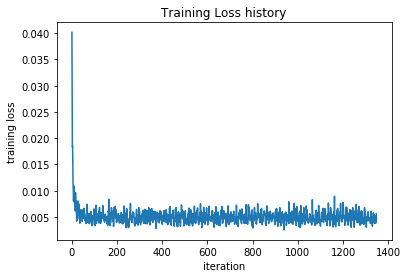

In [20]:
from models.srcnn import SRCNN

# create tensorflow session
with tf.Session() as sess:

    # create SRCNN model
    srcnn = SRCNN(sess,
                  image_size=FLAGS.input_image_size,
                  label_size=FLAGS.label_image_size,
                  batch_size=128,
                  num_epoches=100,
                  channels=FLAGS.channels,
                  stddev=1e-1,
                  learning_rate=1e-5,
                  checkpoint_dir=FLAGS.checkpoint_dir,
                  sample_dir='samples/srcnn')

    # load train dataset
    train_filepath_list = os.path.join(FLAGS.checkpoint_dir, "train_*.tfrecord")
    train_file_list = glob.glob(train_filepath_list)

    # train
    loss_hist = srcnn.train(train_file_list, verbose=True)
    
    # load validate dataset
    val_filepath_list = os.path.join(FLAGS.checkpoint_dir, "valid_*.tfrecord")
    val_file_list = glob.glob(val_filepath_list)
    
    # validate
    Y_hat_val, val_loss = srcnn.predict(val_file_list)

print("validate loss: %.2f" % (val_loss*10000))
    
plt.plot(loss_hist)
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()


### Result detail compare

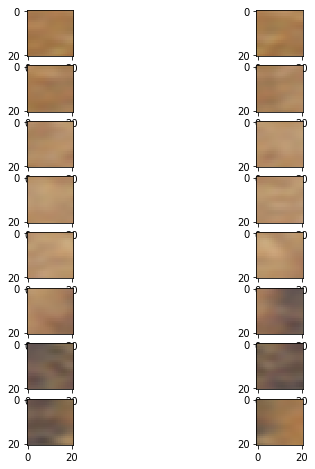

In [51]:

fig = plt.figure(figsize=(8,8))

x_offset, y_offset = (2,2)
for i in range(16):
    
    #plt.subplot(8,6,i*3+1)
    #plt.imshow(X_val[i])
    #plt.subplot(8,6,i*3+2)
    #plt.imshow(Y_val[i])
    plt.subplot(8,6,i*3+3)
    plt.imshow(Y_hat_val[i])


### Show predict

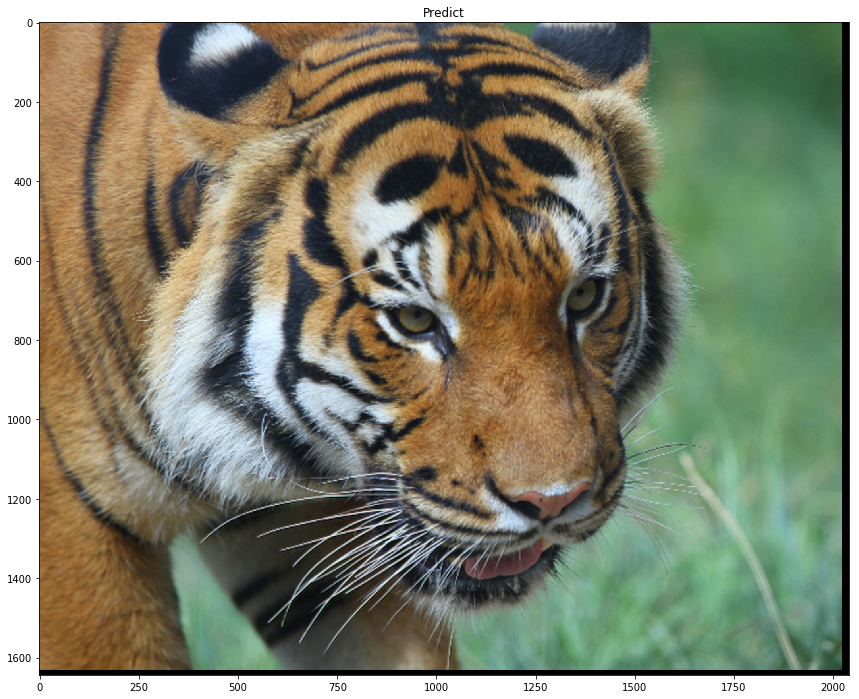

In [53]:
import cv2
def merge_image(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((size[0], size[1], 3))
    num_cols = 1+(size[1]-33+1)//stride
    for idx, image in enumerate(images):
        i = idx % num_cols
        j = idx // num_cols
        img[j*stride:j*stride+h, i*stride:i*stride+w, :] = image

    return img

merged_y_hat = merge_image(Y_hat_val, [1644, 2040])
merged_y_hat[merged_y_hat>=1]=0.999
merged_y_hat[merged_y_hat<0]=0

#merged_y_val = merge_image(Y_val, [1644, 2040])
#merged_x_val = merge_image(X_val, [1644, 2040])

fig = plt.figure(figsize=(16,12))
#plt.subplot(221)
plt.title('Predict')
plt.imshow(merged_y_hat)

plt.savefig("samples/srcnn/0010.png")
#plt.subplot(222)
#plt.title('Groud Truth')
#plt.imshow(merged_y_val)
#plt.subplot(223)
#plt.title('Input')
#plt.imshow(merged_x_val)


### Show weights image

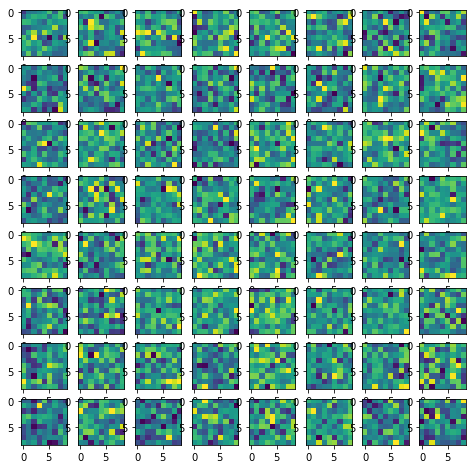

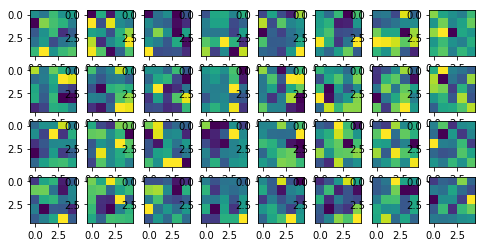

In [25]:

w1 = weights['w1']
w2 = weights['w2']
w3 = weights['w3']

plt.figure(figsize=(8,8))

for i in range(64):
    
    w_img = (w1[:,:,:,i]-np.min(w1[:,:,:,i]))/np.max(w1[:,:,:,i])
    #print(w_img)
    w_img = rgb2gray(w_img)
    plt.subplot(8,8,i+1)
    plt.imshow(w_img)

plt.figure(figsize=(8,8))

for i in range(32):
    
    w_img = (w3[:,:,i,:]-np.min(w3[:,:,i,:]))/np.max(w3[:,:,i,:])
    w_img = rgb2gray(w_img)
    plt.subplot(8,8,i+1)
    plt.imshow(w_img)

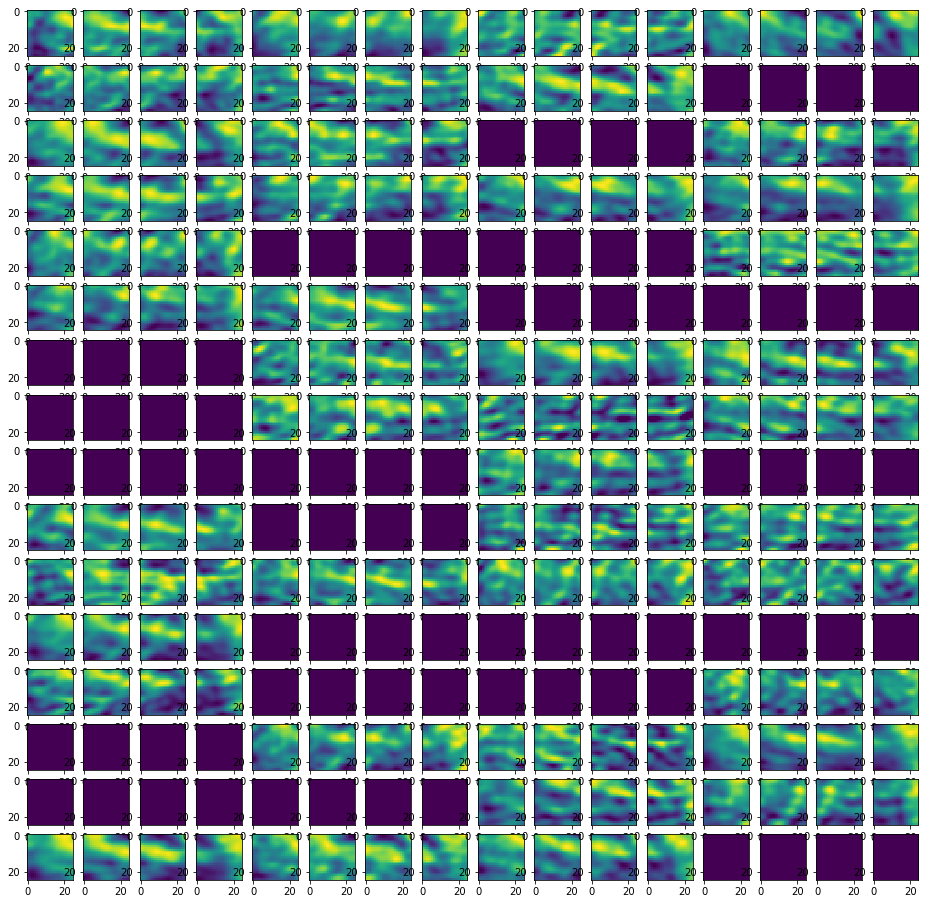

In [26]:
img_layer1 = np.asarray(layer1).reshape(16704,25,25,64)

plt.figure(figsize=(16,16))

for i in range(64):
    
    img = img_layer1[0,:,:,i]
    plt.subplot(16,16,i*4+1)
    plt.imshow(img)
    
    img = img_layer1[1,:,:,i]
    plt.subplot(16,16,i*4+2)
    plt.imshow(img)
    
    img = img_layer1[2,:,:,i]
    plt.subplot(16,16,i*4+3)
    plt.imshow(img)
    
    img = img_layer1[3,:,:,i]
    plt.subplot(16,16,i*4+4)
    plt.imshow(img)